Welcome to JupyROOT 6.28/04
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001414_000.root
*** WARNING: CRV_spill: getTempCMB: Spill # 4 has no actual event
!!! spill 3, 0004 DQM = 0xffffff0000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 5 has no actual event
!!! spill 4, 0005 DQM = 0xff00000000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 9 has no actual event
!!! spill 8, 0009 DQM = 0xffffff0000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 10 has no actual event
!!! spill 9, 0010 DQM = 0xff00000000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 14 has no actual event
!!! spill 13, 0014 DQM = 0xffffff0000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 15 has no actual event
!!! spill 14, 0015 DQM = 0xff00000000000e
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001415_000.root
*** WARNING: CRV_spill: getTempCMB: Spill # 2 has no actual event
!!! spill 1, 0002 DQM = 0xffffff0000000e
*** WARNING: CRV_spill: getTempCMB: Spill # 3 has no actual ev

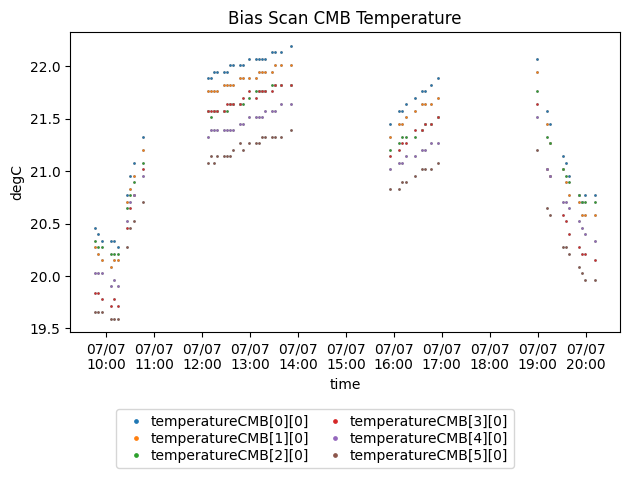

In [1]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

TARGET_OVERVOLTAGE = 3 # V
CONVERSION = 2. # mV/DAC

topdir = os.path.dirname(os.path.abspath("__file__"))
settings_dir = os.path.join(topdir,"settings")

fileList = filepath.getfilelist(["trim_scan_stack_169"],"recoROOT",3)[0]
DeltaTrim = filepath.datatag["trim_scan_stack_169"]["trim"]

nSmooth = 1 
tdict = {'*':[["temperatureCMB[0][0]","temperatureCMB[1][0]","temperatureCMB[2][0]",
               "temperatureCMB[3][0]","temperatureCMB[4][0]","temperatureCMB[5][0]"]]}
tfig = utils.plot_dqm(fileList, tdict, '==0x0', False, nSmooth, True, "Bias Scan CMB Temperature;time;degC") 

In [2]:
nFEB = geometry_constants.setup_dict['crvled-003'][0]['nFEB']
trimSPERaw = [[[] for iCh in range(geometry_constants.nChannelPerFEB)] for iFEB in range(nFEB)]

for filename in fileList:
    calibRaw = utils.calibExtract_root(filename)[1]
    for iFEB in range(nFEB):
        for iCh in range(geometry_constants.nChannelPerFEB):
            trimSPERaw[iFEB][iCh].append(calibRaw[iFEB][iCh])


Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001414_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001415_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001416_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001417_000.root
Loading calibration information from rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.001418_000.root


In [3]:
fGraph_trimSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
func_trimSPE = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
slope_trim = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)]
vover_trim = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)] # overvoltage at 0
relative_trimGoal = [[None]*geometry_constants.nChannelPerFEB for iFEB in range(nFEB)] # overvoltage at 0

pdfname = os.path.join(settings_dir,"biasScanCrvaging008.pdf")

c01 = ROOT.TCanvas("c01", "c01", 640, 480)
c01.Print(pdfname+"[", "pdf")
for iFEB in range(nFEB):
    for iCh in range(geometry_constants.nChannelPerFEB):
        c01.Clear()
                
        fGraph_trimSPE[iFEB][iCh] = ROOT.TGraph(len(DeltaTrim), array('d', DeltaTrim), array('d', trimSPERaw[iFEB][iCh]))
        fGraph_trimSPE[iFEB][iCh].SetName("scat_trimSPE_%i_%i"%(iFEB, iCh))
        fGraph_trimSPE[iFEB][iCh].SetTitle("SPE at Different Bias Settings FEB%i Ch%i; #Deltatrim [ADC]; Calibration Constant [ADC#timesns/PE]"%(iFEB,iCh))
        fGraph_trimSPE[iFEB][iCh].SetMarkerStyle(27)
        fGraph_trimSPE[iFEB][iCh].SetMarkerColor(2)
        fGraph_trimSPE[iFEB][iCh].SetLineColor(2)
        fGraph_trimSPE[iFEB][iCh].SetLineWidth(0)
        fGraph_trimSPE[iFEB][iCh].SetMarkerSize(2)
                
        fGraph_trimSPE[iFEB][iCh].GetXaxis().SetLimits(-600.,600.)
        fGraph_trimSPE[iFEB][iCh].DrawClone("AP")
        
        trim_x_temp = []
        trim_y_temp = []
        
        order = [1,4,0,3,2] # order of runs with decreasing bias
        
        for i in range(len(DeltaTrim)):
            if trimSPERaw[iFEB][iCh][order[i]] != 0.:
                trim_x_temp.append(DeltaTrim[order[i]])
                trim_y_temp.append(trimSPERaw[iFEB][iCh][order[i]])
            else:
                break # if one voltage fails calibration, lower bias should fail calibration too.
                
        if len(trim_x_temp)==0:
            print("DEAD CHANNEL FEB%i CH%i"%(iFEB, iCh))
            print(trimSPERaw[iFEB][iCh])
        else:
            temp_trim_graph = ROOT.TGraph(len(trim_x_temp), array('d', trim_x_temp), array('d', trim_y_temp))

            func_trimSPE[iFEB][iCh] = ROOT.TF1("func_trimSPE_%i_%i"%(iFEB, iCh), "[0]*x+[1]", -600., 600.)
            func_trimSPE[iFEB][iCh].SetParameter(0, -0.25)
            func_trimSPE[iFEB][iCh].SetParameter(1, 400.)
            func_trimSPE[iFEB][iCh].SetParName(0, "k")
            func_trimSPE[iFEB][iCh].SetParName(1, "b")
            func_trimSPE[iFEB][iCh].SetParLimits(0, -100.,0.)
            func_trimSPE[iFEB][iCh].SetParLimits(1, 0.,1000.)
            tfrp_trim = temp_trim_graph.Fit(func_trimSPE[iFEB][iCh], "QRSF")
            func_trimSPE[iFEB][iCh].SetLineColor(2)
            func_trimSPE[iFEB][iCh].SetLineWidth(1)
            # func_trimSPE[iFEB][iCh].SetLineStyle(4)
            func_trimSPE[iFEB][iCh].DrawClone("SAME")
            trim_k = func_trimSPE[iFEB][iCh].GetParameter(0)
            trim_k_err = func_trimSPE[iFEB][iCh].GetParError(0)
            trim_b = func_trimSPE[iFEB][iCh].GetParameter(1)
            trim_b_err = func_trimSPE[iFEB][iCh].GetParError(1)
            slope_trim[iFEB][iCh] = trim_k
            vover_trim[iFEB][iCh] = -trim_b/trim_k*CONVERSION/1000.
            vover_err = abs(vover_trim[iFEB][iCh])*(abs(trim_b_err/trim_b)+abs(trim_k_err/trim_k))
            relative_trimGoal[iFEB][iCh] = -trim_b/trim_k - TARGET_OVERVOLTAGE*1000./CONVERSION
            relative_trimGoal_err = abs(trim_b/trim_k)*(abs(trim_b_err/trim_b)+abs(trim_k_err/trim_k))

            tPT = ROOT.TPaveText(.6, .55, .9, .9, "NDC")
            tPT.SetLineColorAlpha(0,0)
            tPT.SetFillStyle(0)
            tPT.AddText("k = %.3f #pm %.3f"%(trim_k,trim_k_err))
            tPT.AddText("b = %.3f #pm %.3f"%(trim_b,trim_b_err))
            tPT.AddText("V_{over} = %.3f #pm %.3f"%(vover_trim[iFEB][iCh], vover_err))
            tPT.AddText("trim_{Vover=3V} = %.3f #pm %.3f"%(relative_trimGoal[iFEB][iCh], relative_trimGoal_err))
            tPT.DrawClone("SAME") 
        
        c01.Print(pdfname, "Title: FEB%i Ch%i"%(iFEB,iCh))

c01.Print(pdfname+"]", "pdf")

DEAD CHANNEL FEB0 CH33
[0.0, 0.0, 0.0, 0.0, 0.0]


In [4]:
from IPython.display import IFrame
IFrame("settings/biasScanCrvaging008.pdf", width=1200, height=900)

In [5]:
address_1 = ['', '4', '8', 'c']
address_2 = '3'
adreess_3 = ['%x'%(i) for i in range(16)]

trim0 = ['7df','805','7e5','7f8','7c5','7f1','806','7f5',
         '7f9','7dc','7c9','7f9','7f0','7d0','7f5','7d7',
         '803','7da','803','824','7e9','7bb','7f1','7d4',
         '7f4','7f6','7f1','7be','803','7ec','7c9','7e7',
         '7ef','7d5','7ff','7ed','7eb','7f3','7eb','7de',
         '7fb','7d3','7f3','7c1','7e8','7ea','7d2','7d7',
         '7d0','7e9','7f7','7e6','809','7df','7ee','7cb',
         '819','7da','7d3','7e0','7e7','7e0','7d8','7e2']

lasttrim = 0
for iFEB in range(nFEB):
    # each FEB generate one settings file
    fout = open(os.path.join(settings_dir,"Settings_crvaging-008_FEB%i.txt"%(iFEB)),"w")
    fout.write("wr 317 3\n") #sync stuff
    fout.write("wr d 202\n")
    fout.write("wr c 3\n")
    fout.write("wr 40d 202\n")
    fout.write("wr 40c 3\n")
    fout.write("wr 80d 202\n")
    fout.write("wr 80c 3\n")
    fout.write("wr c0d 202\n")
    fout.write("wr c0c 3\n")
    fout.write("wr 44 a78\n") #bulk
    fout.write("wr 45 a98\n")
    fout.write("wr 444 a75\n")
    fout.write("wr 445 a72\n")
    fout.write("wr 844 a83\n")
    fout.write("wr 845 a6c\n")
    fout.write("wr c44 a80\n")
    fout.write("wr c45 a80\n")
    
    for i in range(4):
        for j in range(16):
            a = address_1[i]+address_2+adreess_3[j]
            iCh = 16*i+j
            ttrim0 = int(trim0[iCh], 16)
            if relative_trimGoal[iFEB][iCh]:
                ttrim0 += round(relative_trimGoal[iFEB][iCh])
            if ttrim0<0 or ttrim0>=4096:
                Print("ERROR: %i %i %i"%(iFEB, iCh, ttrim0))
            if relative_trimGoal[iFEB][iCh] is None:
                fout.write("wr %s %x\n"%(a, lasttrim))
            else:
                fout.write("wr %s %x\n"%(a, ttrim0))
                lasttrim = ttrim0
    
    fout.write("wr 46 384\n") # gain
    fout.write("wr 47 384\n")
    fout.write("wr 446 384\n")
    fout.write("wr 447 384\n")
    fout.write("wr 846 384\n")
    fout.write("wr 847 384\n")
    fout.write("wr c46 384\n")
    fout.write("wr c47 384\n")
    fout.write("cmbena 1\n")
    fout.write("wr 304 a0\n") #delay

    fout.close()

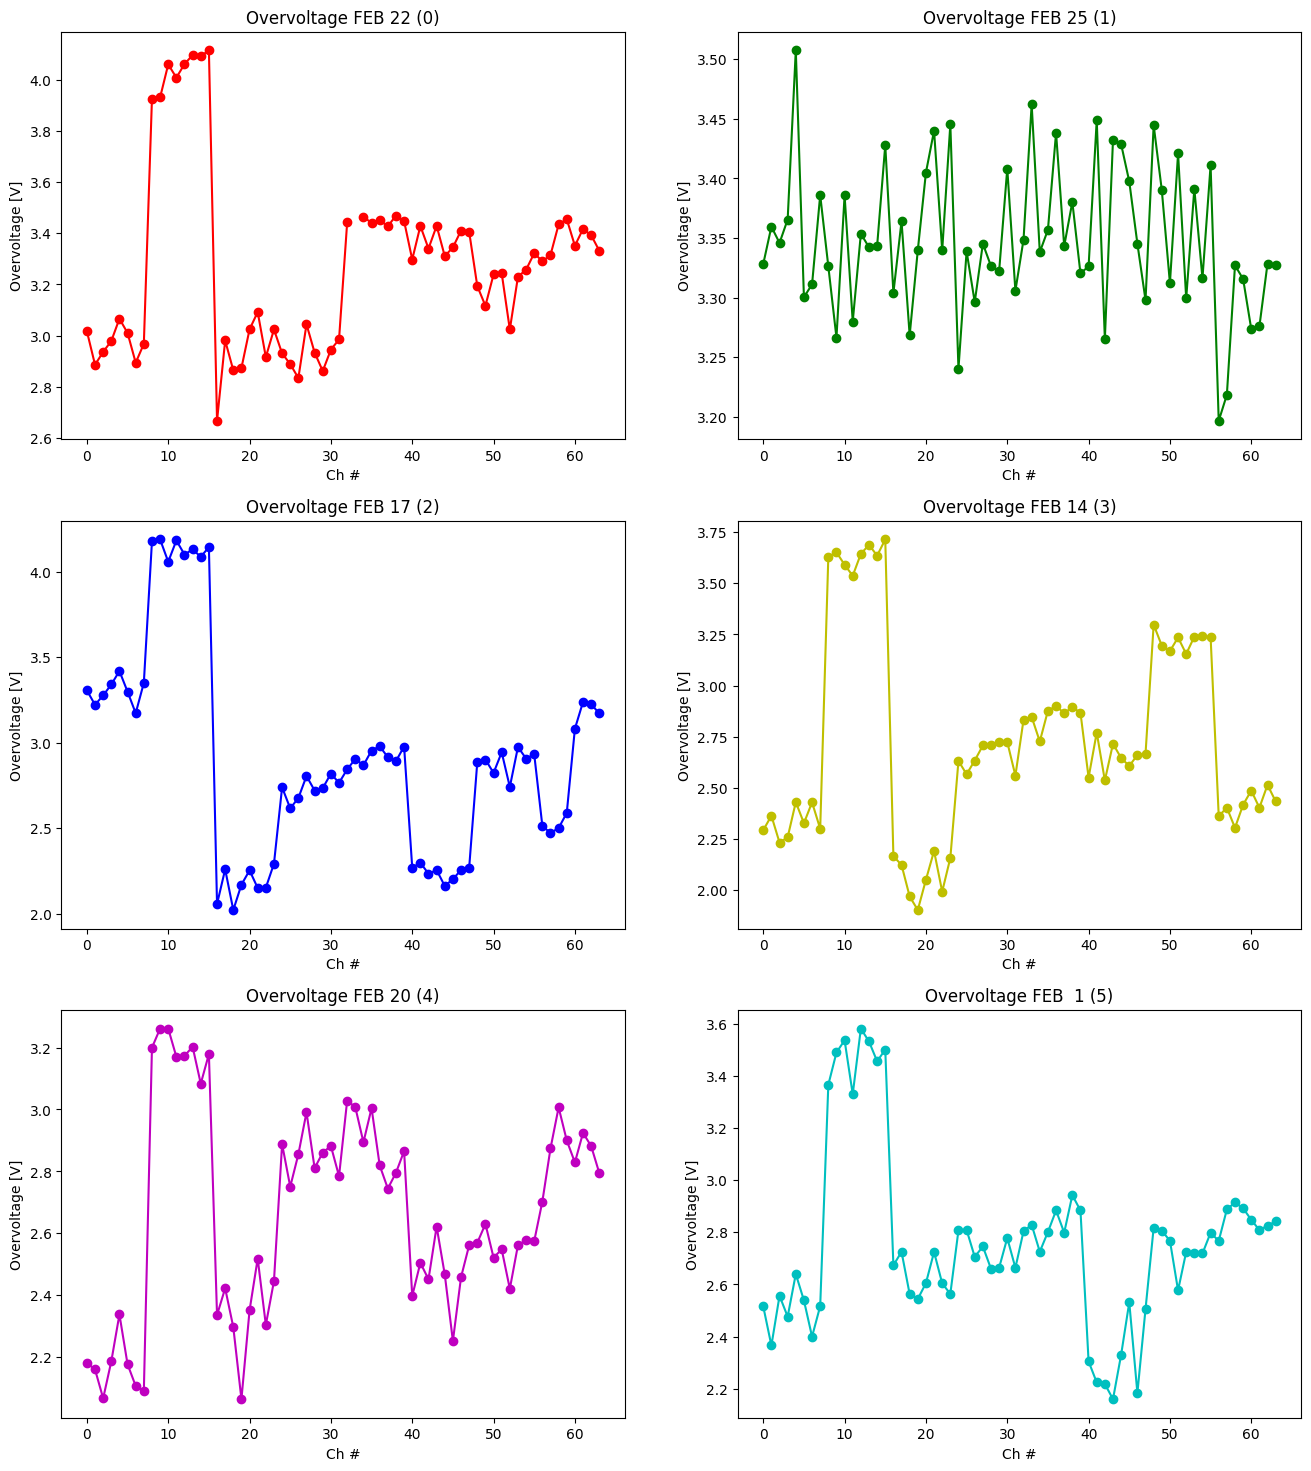

In [6]:
ch_list = [i for i in range(64)]
fig, axes = plt.subplots(3,2,figsize=(16,18))
axes[0,0].plot(ch_list, vover_trim[0], '-o', c='r')
axes[0,0].set_title('Overvoltage FEB 22 (0)')
axes[0,0].set_xlabel('Ch #')
axes[0,0].set_ylabel('Overvoltage [V]')
axes[0,1].plot(ch_list, vover_trim[1], '-o', c='g')
axes[0,1].set_title('Overvoltage FEB 25 (1)')
axes[0,1].set_xlabel('Ch #')
axes[0,1].set_ylabel('Overvoltage [V]')
axes[1,0].plot(ch_list, vover_trim[2], '-o', c='b')
axes[1,0].set_title('Overvoltage FEB 17 (2)')
axes[1,0].set_xlabel('Ch #')
axes[1,0].set_ylabel('Overvoltage [V]')
axes[1,1].plot(ch_list, vover_trim[3], '-o', c='y')
axes[1,1].set_title('Overvoltage FEB 14 (3)')
axes[1,1].set_xlabel('Ch #')
axes[1,1].set_ylabel('Overvoltage [V]')
axes[2,0].plot(ch_list, vover_trim[4], '-o', c='m')
axes[2,0].set_title('Overvoltage FEB 20 (4)')
axes[2,0].set_xlabel('Ch #')
axes[2,0].set_ylabel('Overvoltage [V]')
axes[2,1].plot(ch_list, vover_trim[5], '-o', c='c')
axes[2,1].set_title('Overvoltage FEB  1 (5)')
axes[2,1].set_xlabel('Ch #')
axes[2,1].set_ylabel('Overvoltage [V]')
plt.show()